In [88]:
from typing import TypedDict, Optional, List
from langgraph.graph import StateGraph, END

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.vectorstores import FAISS
from langchain_tavily import TavilySearch
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.documents import Document

from langchain_neo4j import Neo4jGraph
import os
from dotenv import  load_dotenv
load_dotenv()
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
neo4j = Neo4jGraph(url=NEO4J_URI,username=NEO4J_USERNAME,password=NEO4J_PASSWORD,refresh_schema=False)
neo4j


In [89]:

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [90]:
from langchain.chat_models import init_chat_model
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
model = init_chat_model("google_genai:gemini-2.5-flash")

In [91]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="gemma2:2b"
)

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

movie_db = FAISS.load_local(
    "artifacts/movie_faiss_v3",
    embeddings,
    allow_dangerous_deserialization=True
)

In [92]:
tool_search = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [93]:
neo4j = Neo4jGraph(url=NEO4J_URI,username=NEO4J_USERNAME,password=NEO4J_PASSWORD,refresh_schema=False)
neo4j

In [94]:
def run_cypher(query, params=None):
    print(f"--- Executing Cypher ---")
    try:
        # neo4j is a Neo4jGraph instance, use query() method
        return neo4j.query(query, params or {})
    except Exception as e:
        print(f"Cypher Execution Error: {e}")
        return []


In [95]:
class MovieState(TypedDict):
    query: str

    intent: Optional[str]            # plot | movie | complex
    movie_name: Optional[str]
    movie_exists: Optional[bool]

    base_plot: Optional[str]

    kg_movies: Optional[List[str]]

    final_docs: Optional[List[Document]]
    final_answer: Optional[str]


In [96]:
def classify_query(state: MovieState):
    print(f"--- Node: Classify Query ---")
    prompt = f"""
Classify the query strictly into one of the following intents:
1. plot: User describes a plot (Semantic Movie Search Flow).
2. movie_name: User provides a specific movie title (Specific Movie Name Flow).
3. query_search: Complex query or general question requiring AI interpretation (Query Movie Search Flow).

Query:
{state['query']}
"""
    intent = llm.invoke(prompt).content.strip().lower()
    # Basic normalization
    if "plot" in intent: intent = "plot"
    elif "movie" in intent and "name" in intent: intent = "movie_name"
    elif "query" in intent or "complex" in intent: intent = "query_search"
    else: intent = "query_search" # Default fallback
    
    print(f"Identified Intent: {intent}")
    return {"intent": intent}


In [97]:
def extract_movie_name(state: MovieState):
    print(f"--- Node: Extract Movie Name ---")
    prompt = f"""
Extract the specific movie name from the query.
If no specific movie name is found, respond EXACTLY with "NONE".
Query:
{state['query']}
"""
    name = llm.invoke(prompt).content.strip()
    print(f"Extracted Name: {name}")
    if "NONE" in name or not name:
        return {"movie_name": None}
    return {"movie_name": name}


In [98]:
def check_movie_exists(state: MovieState):
    print(f"--- Node: Check Movie Exists ---")
    title = state["movie_name"]
    docs = movie_db.similarity_search(title, k=1)

    exists = bool(docs and title.lower() in docs[0].metadata.get("title","").lower())
    print(f"Movie Exists in DB: {exists}")
    return {"movie_exists": exists}


In [99]:
def get_dataset_plot(state: MovieState):
    print(f"--- Node: Get Dataset Plot ---")
    docs = movie_db.similarity_search(state["movie_name"], k=1)
    print("Retrieved plot from Dataset.")
    return {"base_plot": docs[0].page_content}


In [100]:
def get_web_plot(state: MovieState):
    print(f"--- Node: Get Web Plot ---")
    results = tool_search.invoke(f"{state['movie_name']} movie plot")
    plot = "\n".join(r["content"] for r in results)
    print("Retrieved plot from Web.")
    return {"base_plot": plot}


In [101]:
def kg_agent(state: MovieState):
    print(f"--- Node: KG Agent ---")
    prompt = f"""
Extract entities from the query. Return valid JSON with keys "actor" and "genre".
If not found, set value to null.

Query:
{state['query']}

Example JSON:
{{
  "actor": "Tom Hanks",
  "genre": "Comedy"
}}
"""
    response_text = llm.invoke(prompt).content
    # Clean up markdown code blocks if present
    response_text = response_text.replace("```json", "").replace("```", "").strip()
    
    import json
    try:
        entities = json.loads(response_text)
    except:
        print(f"Failed to parse JSON from LLM: {response_text}")
        entities = {}

    actor = entities.get("actor")
    genre = entities.get("genre")
    print(f"Extracted: actor={actor}, genre={genre}")

    cypher = """
    MATCH (m:Movie)
    OPTIONAL MATCH (m)<-[:ACTED_IN]-(a:Person)
    OPTIONAL MATCH (m)-[:IN_GENRE]->(g:Genre)
    WHERE
        ($actor IS NULL OR toLower(a.name) CONTAINS toLower($actor)) AND
        ($genre IS NULL OR toLower(g.name) CONTAINS toLower($genre))
    RETURN DISTINCT m.title AS title
    LIMIT 20
    """

    params = {
        "actor": actor,
        "genre": genre,
    }

    data = run_cypher(cypher, params)
    print(f"Found {len(data)} movies in KG.")
    return {"kg_movies": [d["title"] for d in data]}


In [102]:
def similarity_search(state: MovieState):
    print(f"--- Node: Similarity Search ---")
    # If we have a list of movies from KG, prioritize searching for them
    if state.get("kg_movies"):
        print("Searching based on KG movie list.")
        docs = []
        for title in state["kg_movies"]:
            docs.extend(movie_db.similarity_search(title, k=2))
    else:
        print("Searching based on Plot Embeddings (Top 5 Extract).")
        # If base_plot is retrieved (from DB or Web), use that. Else use original query.
        query_text = state.get("base_plot") or state["query"]
        docs = movie_db.similarity_search(query_text, k=5)

    return {"final_docs": docs}


In [103]:
def generate_answer(state: MovieState):
    print(f"--- Node: Generate Answer ---")
    context = "\n\n".join(
        d.metadata.get("title","") + ": " + d.page_content[:500]
        for d in state["final_docs"]
    )

    prompt = f"""
Recommend movies based on the context below.

Context:
{context}

User Query:
{state['query']}
"""
    answer = llm.invoke(prompt).content
    print("Answer generated.")
    return {"final_answer": answer}


In [104]:
# Merged into Graph Definition Cell


In [105]:
# Merged into Graph Definition Cell


In [106]:
# --- Routing Logic ---
def route_after_classification(state):
    intent = state.get("intent")
    if intent == "plot":
        return "similarity_search"  # Flow 1: Semantic Search
    elif intent == "movie_name":
        return "extract_movie_name" # Flows 2 & 3: Specific Name
    elif intent == "query_search":
        return "kg_agent"         # Flow 4: Query/KG Search
    return "kg_agent"

def route_after_extraction(state):
    if state.get("movie_name"):
        return "check_movie_exists"
    else:
        # Fallback if classified as movie_name but no name found
        # Could go to plot search or end. Sending to plot search seems safest.
        return "similarity_search"

def route_movie_exists(state):
    if state["movie_exists"]:
        return "get_dataset_plot"  # Flow 2: Existing in Dataset
    return "get_web_plot"          # Flow 3: Web Search

# --- Graph Definition ---
graph = StateGraph(MovieState)

graph.add_node("classify_query", classify_query)
graph.add_node("extract_movie_name", extract_movie_name)
graph.add_node("check_movie_exists", check_movie_exists)
graph.add_node("get_dataset_plot", get_dataset_plot)
graph.add_node("get_web_plot", get_web_plot)
graph.add_node("kg_agent", kg_agent)
graph.add_node("similarity_search", similarity_search)
graph.add_node("generate_answer", generate_answer)

graph.set_entry_point("classify_query")

# Edge 1: Classify -> (Route)
graph.add_conditional_edges(
    "classify_query",
    route_after_classification,
    {
        "similarity_search": "similarity_search",
        "extract_movie_name": "extract_movie_name",
        "kg_agent": "kg_agent"
    }
)

# Edge 2: Extract Name -> (Route Check or Fallback)
graph.add_conditional_edges(
    "extract_movie_name",
    route_after_extraction,
    {
        "check_movie_exists": "check_movie_exists",
        "similarity_search": "similarity_search"
    }
)

# Edge 3: Check Exists -> (Route YES/NO)
graph.add_conditional_edges(
    "check_movie_exists",
    route_movie_exists,
    {
        "get_dataset_plot": "get_dataset_plot",
        "get_web_plot": "get_web_plot"
    }
)

# Convergence to Similarity Search
graph.add_edge("get_dataset_plot", "similarity_search")
graph.add_edge("get_web_plot", "similarity_search")
graph.add_edge("kg_agent", "similarity_search")

# Final Answer
graph.add_edge("similarity_search", "generate_answer")
graph.add_edge("generate_answer", END)

app = graph.compile()


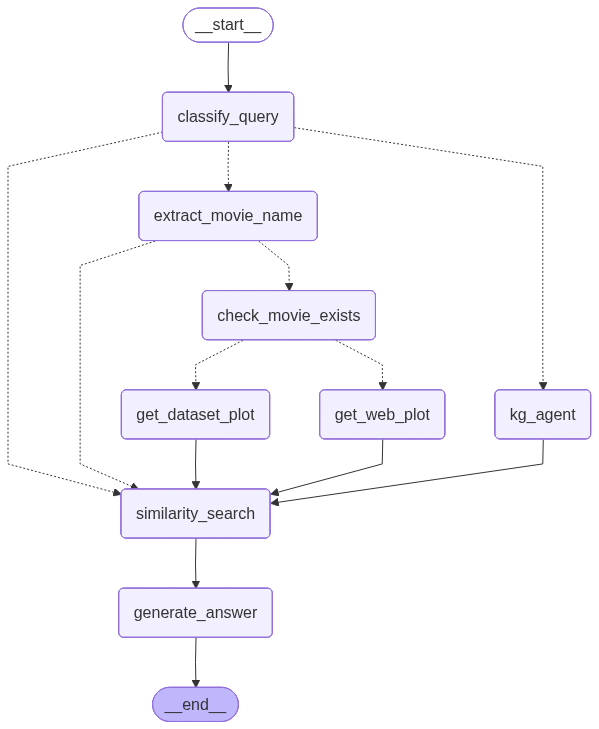

In [107]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [108]:
result = app.invoke({
    "query": "“asdfghjkl movie stuff "
})

print(result["final_answer"])


--- Node: Classify Query ---
Identified Intent: plot
--- Node: Similarity Search ---
Searching based on Plot Embeddings (Top 5 Extract).
--- Node: Generate Answer ---
Answer generated.
Based on the context you provided, here are some movie recommendations that might resonate with you:

**Themes Aligned with "Fukrey Returns" - Heist Comedy:**

* **Upgrade (2018):**  A cyberpunk action film about a man who is given new abilities after being left for dead. 
* **Snatch (2000):** A fast-paced, hilarious crime caper filled with memorable characters and non-stop action.
* **The Nice Guys (2016):** Two private detectives from different worlds team up to solve a missing person case in 1970s Los Angeles. 

**Themes Aligned with "The Silenced" - Coming of Age & Social Commentary:**

* **Lost in Translation (2003):** A poignant film about two lonely Americans finding connection in Tokyo amidst their own personal struggles.
* **City Lights (1931) :**  An early American silent film about a man who f

In [109]:
result = app.invoke({
    "query": "Recommend something good. "
})

print(result["final_answer"])


--- Node: Classify Query ---
Identified Intent: query_search
--- Node: KG Agent ---
Extracted: actor=None, genre=None
--- Executing Cypher ---
Found 20 movies in KG.
--- Node: Similarity Search ---
Searching based on KG movie list.
--- Node: Generate Answer ---
Answer generated.
It's tough to recommend without knowing your preferences!  To give you a good suggestion, tell me: 

* **What genres do you like?** (e.g., action, romance, thriller, comedy) 
* **Do you prefer classic movies or newer ones?**
* **Are there any actors, directors, or time periods you particularly enjoy?**
* **Is there a particular tone you're looking for?**  (e.g., lighthearted, suspenseful, thought-provoking)

The more info you give me, the better I can tailor a recommendation! 🍿🎬 😄 



In [110]:
result = app.invoke({
    "query": "Movie like Metro in dino. "
})

print(result["final_answer"])

--- Node: Classify Query ---
Identified Intent: plot
--- Node: Similarity Search ---
Searching based on Plot Embeddings (Top 5 Extract).
--- Node: Generate Answer ---
Answer generated.
Based on your context and user query, here are some movie recommendations that might appeal to you, drawing parallels to "Metro" which is likely about a child-centric adventure or story set against the backdrop of dinosaurs:


**Themes & Similarities:**

* **Dino Time (1987):** This one's a classic. It dives into the "what if?" scenario of children living in a dinosaur world. 
* **Dinosaurs! – A Fun-Filled Trip Back in Time!:**  This one features similar themes, with young kids exploring the prehistoric period. It also leans heavily on humor and adventure.
* **Kadhavasheshan:** This film uses a "Rashomon" style storytelling method that might be interesting if you enjoy intricate narrative structure and mystery.


**Additional Recommendations Based on User Query**:

* **The Iron Giant (1999):**  A heartwa

In [111]:
# --- VERIFICATION ---
print("Running Verification Tests for 4 Flows...")

# 1. Plot Path
print("\n1. Testing Plot Path...")
try:
    res1 = app.invoke({"query": "A movie about falling in love on a sinking ship"})
    print(f"Result 1: {res1.get('final_answer')[:100]}...")
except Exception as e: print(f"Error: {e}")

# 2. Existing Movie Path
print("\n2. Testing Existing Movie Path...")
try:
    res2 = app.invoke({"query": "The Matrix"})
    print(f"Result 2: {res2.get('final_answer')[:100]}...")
except Exception as e: print(f"Error: {e}")

# 3. Web Search Path (Non-existent movie)
print("\n3. Testing Web Search Path...")
try:
    # Using a name likely not in your DB but real enough for web search
    res3 = app.invoke({"query": "Dune: Part Two"})
    print(f"Result 3: {res3.get('final_answer')[:100]}...")
except Exception as e: print(f"Error: {e}")

# 4. KG/Query Path
print("\n4. Testing KG Agent Path...")
try:
    res4 = app.invoke({"query": "Movies directed by Christopher Nolan with Sci-Fi elements"})
    print(f"Result 4: {res4.get('final_answer')[:100]}...")
except Exception as e: print(f"Error: {e}")


Running Verification Tests for 4 Flows...

1. Testing Plot Path...
--- Node: Classify Query ---
Identified Intent: plot
--- Node: Similarity Search ---
Searching based on Plot Embeddings (Top 5 Extract).
--- Node: Generate Answer ---
Answer generated.
Result 1: Based on your request for a movie about falling in love on a sinking ship, here are some recommendat...

2. Testing Existing Movie Path...
--- Node: Classify Query ---
Identified Intent: plot
--- Node: Similarity Search ---
Searching based on Plot Embeddings (Top 5 Extract).
--- Node: Generate Answer ---
Answer generated.
Result 2: It sounds like you enjoy action movies with themes of fighting for freedom and understanding the nat...

3. Testing Web Search Path...
--- Node: Classify Query ---
Identified Intent: plot
--- Node: Similarity Search ---
Searching based on Plot Embeddings (Top 5 Extract).
--- Node: Generate Answer ---
Answer generated.
Result 3: Based on your context and user query, here are some movie recommendations 